In [1]:
%cd "~/Projects/Segmentation/TreeSeg"

/home/wan/Projects/Segmentation/TreeSeg


In [2]:
import json
import math
import os
from pathlib import Path

import hashlib
import matplotlib.pyplot as plt
import networkx as nx
import nvdiffrast.torch as dr
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import yaml
from rich.console import Console
from rich.tree import Tree
import torch_geometric as pyg

import tree_segmentation.extension as ext
from tree_segmentation.extension import ops_3d, Mesh, utils
from semantic_sam import SemanticSAM, semantic_sam_l
from tree_segmentation import Tree3Dv2, Tree3D, TreePredictor, TreeSegmentMetric, TreeData
from tree_segmentation.util import show_masks, show_all_levels
from tree_segmentation.batch_eval_PartNet import get_mesh_and_gt_tree, get_images

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2023-07-28 13:38:17.114419: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 13:38:17.955197: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/wan/miniconda3/envs/wan/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:
2023-07-28 13:38:17.955324: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so

In [3]:
print(torch.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline

2.0.1+cu117


In [4]:
torch.set_grad_enabled(False)
console = Console()
device = torch.device("cuda")
cache_root = Path('~/wan_code/segmentation/tree_segmentation/results').expanduser()
utils.set_printoptions(linewidth=120)

In [5]:
data_root = Path('~/data/PartNet/data_v0').expanduser()
print(f"Data Root: {data_root}")
shapes = list(os.scandir(data_root))
print(f'There are {len(shapes)} shapes')

Data Root: /home/wan/data/PartNet/data_v0
There are 32537 shapes


In [6]:
# example = data_root.joinpath('12012')
example = data_root.joinpath('22835')
# example = data_root.joinpath('27774')
print(f"Example dir", example)
cache_dir = cache_root.joinpath(hashlib.md5(str(example.joinpath('objs').resolve()).encode()).hexdigest())
cache_dir.mkdir(exist_ok=True)
print('Cache Dir:', cache_dir)
# with example.joinpath('meta.json').open('r') as f:
#     meta = json.load(f)
# print('meta:', meta)
# with example.joinpath('result_after_merging.json').open('r') as f:
#     meta_parts = json.load(f)
# print(list(os.scandir(example)))
# for item in os.scandir(example):
#     print('=' * 20, item.name, '=' * 20)
#     if item.name.endswith('.json'):
#         with example.joinpath(item.name).open('r') as f:
#             data = json.load(f)
#             print(yaml.dump(data))

Example dir /home/wan/data/PartNet/data_v0/22835
Cache Dir: /home/wan/wan_code/segmentation/tree_segmentation/results/1b44f4e4724b07e54df71eef5e7f6d28


In [7]:
if cache_dir.joinpath(example.stem + '.mesh_cache').exists() and cache_dir.joinpath('gt.tree3dv2').exists():
    mesh = torch.load(cache_dir.joinpath(example.stem + '.mesh_cache'), map_location=device)
    gt = Tree3Dv2(mesh, device=device)
    gt.load(cache_dir.joinpath('gt.tree3dv2'))
else:
    mesh, gt = get_mesh_and_gt_tree(example, cache_dir)
print(mesh, gt)
gt.print_tree()

[Tree3D] load results from: /home/wan/wan_code/segmentation/tree_segmentation/results/1b44f4e4724b07e54df71eef5e7f6d28/gt.tree3dv2
Mesh(vertices=75979, faces=30568) <tree_segmentation.tree_3d_segmentation.Tree3Dv2 object at 0x7fba3c409ee0>


0: Tree Root
├── 1
└── 2
    ├── 3
    ├── 4
    ├── 5
    ├── 6
    ├── 7
    ├── 8
    ├── 9
    ├── 10
    ├── 11
    │   ├── 13
    │   └── 14
    └── 12
        ├── 15
        └── 16

F32Tensor[10, 3], F32Tensor[10, 4, 4]
F32Tensor[10, 3], F32Tensor[10, 4, 4]
F32Tensor[10, 3], F32Tensor[10, 4, 4]
F32Tensor[10, 3], F32Tensor[10, 4, 4]
F32Tensor[10, 3], F32Tensor[10, 4, 4]
F32Tensor[10, 3], F32Tensor[10, 4, 4]
F32Tensor[10, 3], F32Tensor[10, 4, 4]
F32Tensor[10, 3], F32Tensor[10, 4, 4]
F32Tensor[10, 3], F32Tensor[10, 4, 4]
F32Tensor[10, 3], F32Tensor[10, 4, 4]
F32Tensor[100, 1024, 1024, 3], IntTensor[100, 1024, 1024], F32Tensor[100, 4, 4]


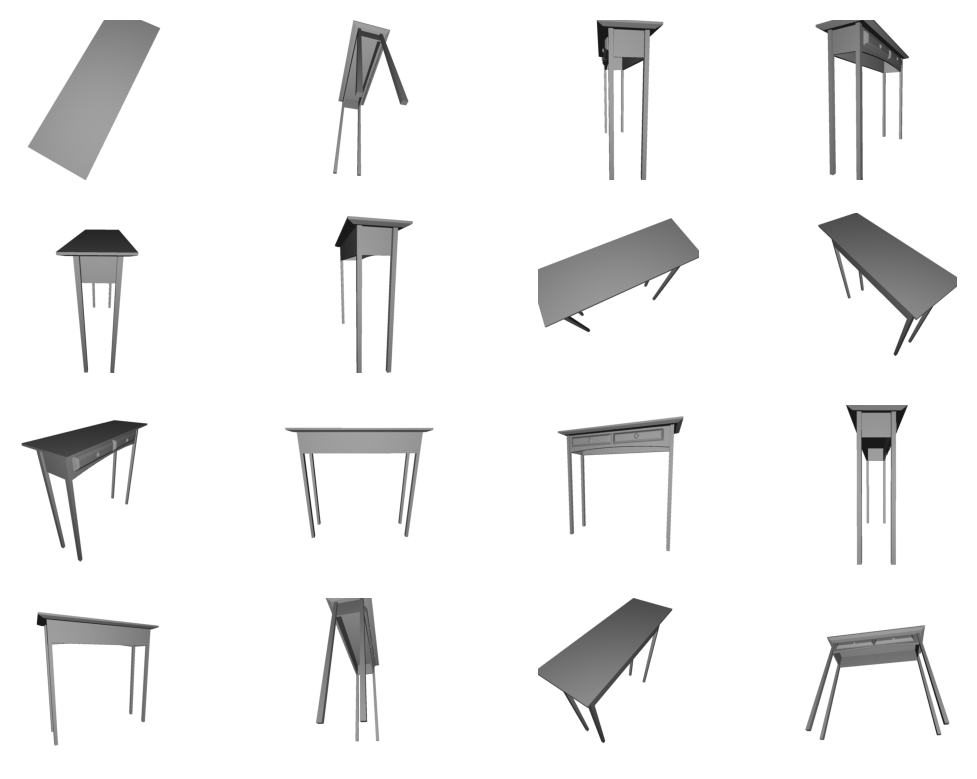

In [8]:
num_views = 100
images, tri_ids, Tw2vs = get_images(mesh.to(device), image_size=1024, num_views=num_views, seed=42)
images, tri_ids, Tw2vs = images.cpu(), tri_ids.cpu(), Tw2vs.cpu()
print(utils.show_shape(images, tri_ids, Tw2vs))
plt.figure(dpi=200)
for i in range(min(16, images.shape[0])):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].cpu().numpy())
    plt.axis('off')

In [ ]:
show_index = 8
num_level = show_all_levels(images[show_index, :, :, :3], gt, tri_ids[show_index], facecolor='lightgray')
plt.show()

In [ ]:
ckpt_path = Path("~/models/segmentation/Semantic-SAM/swinl_only_sam_many2many.pth").expanduser()
model = semantic_sam_l(ckpt_path).eval().to(device)
print(model)
predictor = TreePredictor(model)

In [ ]:
def build_view_graph(area, tri_ids: Tensor, threshold=0.5, num_nearest=5):
    N_view = tri_ids.shape[0]
    view_masks = torch.zeros((N_view, area.shape[0]), device=device)
    for i in range(N_view):
        v_faces = tri_ids[i].unique()
        if v_faces[0] == 0:
            v_faces = v_faces[1:]
        view_masks[i, v_faces] = 1
    area = torch.mv(view_masks[:, 1:], area)
    # print(area.shape)
    A = F.linear(view_masks[:, 1:], view_masks[:, 1:] * area)
    # A = A / (area[:, None] + area[None, :] - A).clamp_min(1e-7)
    A = A / area[:, None]
    indices = torch.topk(A, num_nearest + 1, dim=0)[1]
    # print(utils.show_shape(indices))
    A = A.ge(threshold)
    A[torch.arange(N_view), indices] = 1
    return A


Gv = build_view_graph(gt.area, tri_ids)

In [ ]:
features_2d = []
for i in range(num_views):
    predictor.set_image(images[i, :, :, :3].cpu().numpy())
    features_2d.append(utils.tensor_to(predictor.features, device=torch.device('cpu')))
print(utils.show_shape(features_2d))

In [ ]:
results_2d = [TreeData(device=device) for _ in range(num_views)]
for i in range(num_views):
    points = results_2d[i].sample_grid(32)
    predictor.features = features_2d[i]
    data = predictor.process_points(points)
    results_2d[i].cat(data)
    results_2d[i].update_tree()
    results_2d[i].remove_not_in_tree()
for j in range(10):
    for i in range(num_views):
        points = []

In [ ]:
show_index = 8
image = images[show_index, :, :, :3]
print('image:', utils.show_shape(image))
tree_data = predictor.generate(
    (image.cpu().numpy() * 255).astype(np.uint8),
    max_iters=100,
    in_threshold=0.9,
    union_threshold=0.1,
    min_mask_region_area=100,
    points_per_update=256,
    device=device,
    in_thre_area=50,
)
show_all_levels(image, tree_data, facecolor='lightgray', width=6)

In [10]:
# from rich.progress import track
from IPython.display import clear_output

for index in tqdm(range(num_views)):
    if cache_dir.joinpath(f"view_{index:04d}.data").exists():
        data = torch.load(cache_dir.joinpath(f"view_{index:04d}.data"), map_location='cpu')
        assert torch.all(data['tri_id'].eq(tri_ids[index].cpu()))
    else:
        tree_data = predictor.generate(
            (images[index, :, :, :3].cpu().numpy() * 255).astype(np.uint8),
            max_iters=100,
            in_threshold=0.9,
            union_threshold=0.1,
            min_mask_region_area=100,
            points_per_update=256,
            device=device,
            in_thre_area=50,
        )
        data = {
            'tree_data': tree_data.save(filename=None),
            'tri_id': tri_ids[index].clone(),
            'image': images[index].clone(),
            'Tw2v': Tw2vs[index].clone(),
        }
        torch.save(data, cache_dir.joinpath(f"view_{index:04d}.data"))

    clear_output(wait=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.01it/s]


In [11]:
tree3d = Tree3Dv2(mesh, device=device)
# tree3d.load(cache_dir.joinpath('my.tree3dv2'))
tree3d.load_2d_results(cache_dir)
Gv = tree3d.build_view_graph()
Gm = tree3d.build_graph(Gv)
X, autoencoder = tree3d.compress_masks(epochs=5000)
print(autoencoder)

[Tree3D] GPU: (3.1350483894348145, 11.904052734375)
[Tree3D] There are 100 data
[Tree3D] {'tree_data': {'masks': IntTensor[3, 1024, 1024], 'iou_preds': F16Tensor[6], 'area': LongTensor[6], 'parent': IntTensor[7], 'first': IntTensor[7], 'next': IntTensor[7], 'last': IntTensor[7], 'cnt': 6, 'num_samples': IntTensor[7], 'extra': {}}, 'tri_id': LongTensor[1024, 1024], 'image': F32Tensor[1024, 1024, 4], 'Tw2v': F32Tensor[4, 4]}
[Tree3D] GPU: (0.010155200958251953, 11.904052734375)
[Tree3D] view_masks, view_infos[0]: F32Tensor[100, 30569], (LongTensor[2], LongTensor[2])
[Tree3D] loaded 100 views, 1540 masks, max_num: 35
[Tree3D] GPU: (1.986861228942871, 11.904052734375)
[Tree3D] X epoch[   0], loss: recon= 0.709, lr=1.000e-03
[Tree3D] X epoch[ 100], loss: recon= 0.204, lr=9.990e-04
[Tree3D] X epoch[ 200], loss: recon= 0.051, lr=9.960e-04
[Tree3D] X epoch[ 300], loss: recon= 0.038, lr=9.911e-04
[Tree3D] X epoch[ 400], loss: recon= 0.032, lr=9.842e-04
[Tree3D] X epoch[ 500], loss: recon= 0.028

In [19]:
K = tree3d.Lmax * 2
gnn = pyg.nn.GCN(
    in_channels=X.shape[1],
    hidden_channels=128,
    num_layers=2,
    out_channels=K,
    norm='BatchNorm'
).cuda()
print(gnn)
tree3d.run(epochs=10000, K=K, gnn=gnn, A=Gm * Gm.ge(0.5), X=X)
tree3d.save(cache_dir.joinpath('my.tree3dv2'))

GCN(256, 70, num_layers=2)
[Tree3D] GPU: (3.376675605773926, 11.904052734375)
[Tree3D] GPU: (3.224170207977295, 11.904052734375)
[Tree3D] GPU: (3.2246150970458984, 11.904052734375)
[Tree3D] Epoch 100: loss=1.542997, match= 0.819, mm= 0.835
[Tree3D] Epoch 200: loss=1.674329, match= 0.708, mm= 0.758
[Tree3D] Epoch 300: loss=1.174646, match= 0.706, mm= 0.757
[Tree3D] Epoch 400: loss=1.166666, match= 0.678, mm= 0.730
[Tree3D] Epoch 500: loss=1.356421, match= 0.640, mm= 0.708
[Tree3D] Epoch 600: loss=1.157632, match= 0.616, mm= 0.685
[Tree3D] Epoch 700: loss=1.363055, match= 0.600, mm= 0.654
[Tree3D] Epoch 800: loss=1.318063, match= 0.588, mm= 0.648
[Tree3D] Epoch 900: loss=1.999996, match= 0.568, mm= 0.632
[Tree3D] Epoch 1000: loss=1.438526, match= 0.565, mm= 0.627
[Tree3D] Epoch 1100: loss=1.045589, match= 0.582, mm= 0.636
[Tree3D] Epoch 1200: loss=0.993662, match= 0.519, mm= 0.573
[Tree3D] Epoch 1300: loss=1.032593, match= 0.529, mm= 0.588
[Tree3D] Epoch 1400: loss=1.139774, match= 0.525

In [ ]:
# if gnn is not None:
#     # gnn.reset_parameters()
#     tree3d.run(epochs=5000, K=K, gnn=gnn, A=Gm * Gm.ge(0.5), X=X)

[Tree3D] set score theshold=0.5
tensor([0.9938, 0.9931, 0.9575, 0.9476, 0.9396, 0.9363, 0.9363, 0.9322, 0.9321, 0.9141, 0.9110, 0.9042, 0.9042, 0.8853,
        0.8816, 0.8807, 0.8674, 0.8594, 0.8352, 0.6166, 0.6713, 0.6714, 0.6796, 0.7142, 0.7260, 0.7618, 0.7658, 0.7838,
        0.7856, 0.7944, 0.8067, 0.8173, 0.8260, 0.8316, 0.8328, 0.5107, 0.5171, 0.5227, 0.5390, 0.5634, 0.5668, 0.5940,
        0.5994, 0.4852, 0.4413, 0.4124, 0.3620, 0.3612, 0.3562, 0.3434, 0.3265, 0.3261, 0.3037, 0.3010, 0.2878, 0.2834,
        0.2826, 0.2632, 0.2549, 0.2510, 0.2422, 0.2280, 0.2043, 0.1712, 0.1248, 0.0891, 0.0724, 0.0700, 0.0484, 0.0073],
       device='cuda:0')


0: Tree Root
├── 43
├── 42
├── 41
├── 40
├── 39
├── 38
├── 37
├── 36
├── 35
├── 34
├── 33
├── 32
├── 31
├── 30
├── 29
├── 28
├── 27
├── 26
├── 25
├── 24
├── 23
├── 22
├── 21
├── 20
├── 19
├── 18
├── 17
├── 16
├── 15
├── 14
├── 13
├── 12
├── 11
├── 10
├── 9
├── 8
├── 7
├── 6
├── 5
├── 4
├── 3
├── 2
└── 1

BoolTensor[70, 30569]
[-1 -1 -1 14 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 11 -1  0 -1 -1 -1 -1 -1 -1 -1  6 -1  3 -1 -1 -1 -1  5 10 -1 -1  7
  2 -1  4 -1]
[0.     0.     0.     0.7132 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.7294 0.     0.5342 0.     0.     0.     0.     0.     0.     0.     0.5634 0.     0.8163 0.     0.     0.     0.
 0.7562 0.5711 0.     0.     0.8146 0.8246 0.     0.8761 0.    ]
[19 -1 39 29 41 34 27 38 -1 -1 35 17 -1 -1  3 -1]
[0.5342 0.     0.8246 0.8163 0.8761 0.7562 0.5634 0.8146 0.     0.     0.5711 0.7294 0.     0.     0.7132 0.    ]
0.24403416908393472 0.44993799924850464


0: Tree Root
├── 1
├── 2
├── 3
├── 4
├── 5
├── 6
├── 7
├── 8
├── 9
├── 10
├── 11
├── 12
├── 13
├── 14
├── 15
├── 16
├── 17
├── 18
├── 19
├── 20
├── 21
├── 22
├── 23
├── 24
├── 25
├── 26
├── 27
├── 28
├── 29
├── 30
├── 31
├── 32
├── 33
├── 34
├── 35
├── 36
├── 37
├── 38
├── 39
├── 40
├── 41
├── 42
└── 43

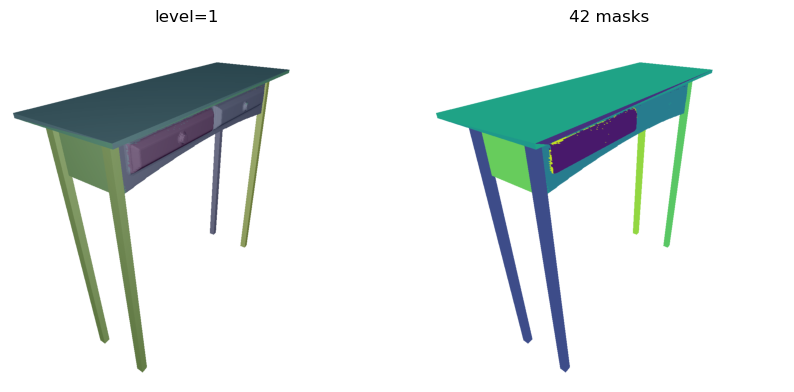

In [24]:
tree3d.set_score_threshold(0.5)
show_index = 8
show_all_levels(images[show_index, :, :, :3], tree3d, tri_ids[show_index])
tree3d.print_tree()
print(utils.show_shape(tree3d.masks))
# tree3d.save(cache_dir.joinpath('my.tree3dv2'))

metric = TreeSegmentMetric()
metric.update(tree3d.to(device), gt.to(device))
print(metric.summarize(), metric.gt_iou_sum / metric.cnt)
tree3d.print_tree()

In [14]:
tree3d_gt = Tree3Dv2(mesh, device, verbose=1)
tree3d_gt.build_gt_segmentation(gt, tri_ids)
Gv_ = tree3d_gt.build_view_graph()
Gm_ = tree3d_gt.build_graph(Gv_)
X_, autoencoder = tree3d_gt.compress_masks(epochs=5000)
print(autoencoder)
print(utils.show_shape(Gv_, Gm_, X_))

[Tree] reset
[Tree3D] view_masks, view_infos[0]: F32Tensor[100, 30569], (IntTensor[2], LongTensor[2])
[Tree3D] loaded 100 views, 1082 masks, max_num: 16
[Tree3D] start build view graph
[Tree3D] start build graph
[Tree3D] X epoch[   0], loss: recon= 0.711, lr=1.000e-03
[Tree3D] X epoch[ 100], loss: recon= 0.191, lr=9.990e-04
[Tree3D] X epoch[ 200], loss: recon= 0.054, lr=9.960e-04
[Tree3D] X epoch[ 300], loss: recon= 0.039, lr=9.911e-04
[Tree3D] X epoch[ 400], loss: recon= 0.032, lr=9.842e-04
[Tree3D] X epoch[ 500], loss: recon= 0.030, lr=9.755e-04
[Tree3D] X epoch[ 600], loss: recon= 0.027, lr=9.648e-04
[Tree3D] X epoch[ 700], loss: recon= 0.025, lr=9.523e-04
[Tree3D] X epoch[ 800], loss: recon= 0.024, lr=9.381e-04
[Tree3D] X epoch[ 900], loss: recon= 0.022, lr=9.221e-04
[Tree3D] X epoch[1000], loss: recon= 0.020, lr=9.044e-04
[Tree3D] X epoch[1100], loss: recon= 0.020, lr=8.852e-04
[Tree3D] X epoch[1200], loss: recon= 0.018, lr=8.644e-04
[Tree3D] X epoch[1300], loss: recon= 0.016, lr=

In [ ]:
print('view graph:', Gv_.shape, 'edges:', Gv_.sum().item())

G_ = nx.Graph()
G_.add_nodes_from(range(Gv_.shape[0]))
for ab in torch.nonzero(Gv_):
    a, b = ab[0].item(), ab[1].item()
    if a < b:
        G_.add_edge(a, b)
plt.figure(figsize=(10, 10))
nx.draw(G_, node_size=5)
plt.show()


In [17]:
K = gt.cnt * 2
gnn = pyg.nn.GCN(
    in_channels=X_.shape[1],
    hidden_channels=128,
    num_layers=2,
    out_channels=K,
    norm='BatchNorm'
).cuda()
print(gnn)

tree3d_gt.run(epochs=5000, K=K, gnn=gnn, A=Gm_ * (Gm_ > 0.5), X=X_)
tree3d_gt.save(cache_dir.joinpath('gt_gnn.tree3dv2'))

GCN(256, 32, num_layers=2)
[Tree3D] GPU: (3.3754873275756836, 11.904052734375)
[Tree3D] GPU: (3.2194018363952637, 11.904052734375)
[Tree3D] GPU: (3.219909191131592, 11.904052734375)
[Tree3D] Epoch 100: loss=1.081526, match= 0.575, mm= 0.649
[Tree3D] Epoch 200: loss=0.826501, match= 0.476, mm= 0.551
[Tree3D] Epoch 300: loss=0.767393, match= 0.312, mm= 0.448
[Tree3D] Epoch 400: loss=0.508678, match= 0.224, mm= 0.367
[Tree3D] Epoch 500: loss=0.492544, match= 0.141, mm= 0.313
[Tree3D] Epoch 600: loss=0.288538, match= 0.098, mm= 0.268
[Tree3D] Epoch 700: loss=0.355403, match= 0.067, mm= 0.250
[Tree3D] Epoch 800: loss=0.258079, match= 0.059, mm= 0.238
[Tree3D] Epoch 900: loss=0.203831, match= 0.048, mm= 0.222
[Tree3D] Epoch 1000: loss=0.219712, match= 0.050, mm= 0.213
[Tree3D] Epoch 1100: loss=0.168462, match= 0.046, mm= 0.204
[Tree3D] Epoch 1200: loss=0.302640, match= 0.041, mm= 0.197
[Tree3D] Epoch 1300: loss=0.244247, match= 0.049, mm= 0.192
[Tree3D] Epoch 1400: loss=0.168295, match= 0.04

In [ ]:
# tree3d_gt.save(cache_dir.joinpath('gt_gnn.tree3dv2'))
print(tree3d_gt.scores)

[Tree] rerange nodes


0: Tree Root
├── 1
├── 2
├── 3
├── 4
├── 5
├── 6
├── 7
├── 8
├── 9
├── 10
├── 11
├── 12
├── 13
├── 14
├── 15
├── 16
├── 17
└── 18

[Tree] rerange nodes
[-1  9 15  0 -1 -1  5 11 -1  6  4 13  3  8 10  2  7  1]
[0.     0.9246 0.7471 0.9915 0.     0.     0.7597 0.7426 0.     0.8565 0.9347 0.7169 0.9329 0.8628 0.724  0.8728 0.8455
 0.9158]
[ 3 17 15 12 10  6  9 16 13  1 14  7 -1 11 -1  2]
[0.9915 0.9158 0.8728 0.9329 0.9347 0.7597 0.8565 0.8455 0.8628 0.9246 0.724  0.7426 0.     0.7169 0.     0.7471]
0.6957306581384995 0.739213764667511


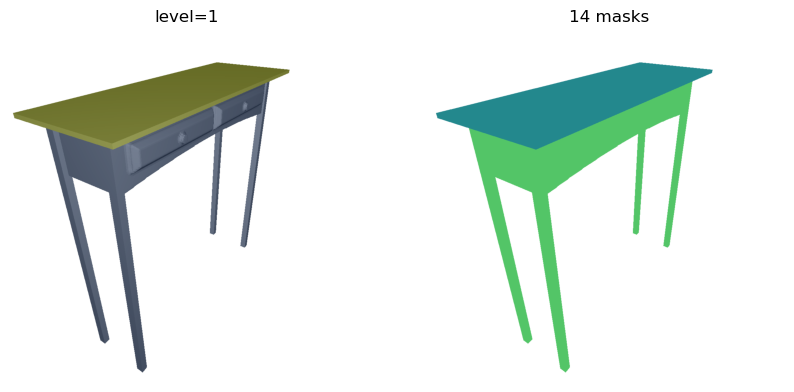

In [18]:
show_index = 8
show_all_levels(images[show_index, :, :, :3], tree3d_gt, tri_ids[show_index])
tree3d_gt.node_rearrange()
tree3d_gt.print_tree()
metric = TreeSegmentMetric()
metric.update(tree3d_gt.to(device), gt.to(device))
print(metric.summarize(), metric.gt_iou_sum / metric.cnt)

In [ ]:
@torch.enable_grad()
def run(Adj: Tensor, Attr: Tensor, t: Tree3Dv2, epochs=5000):
    gnn = pyg.nn.GCN(
        in_channels=X_.shape[1],
        hidden_channels=128,
        num_layers=2,
        out_channels=128,
        norm='BatchNorm'
    ).cuda()

    opt = torch.optim.Adam(gnn.parameters(), lr=5e-4)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, epochs, 1e-6)

    edges = torch.nonzero(Adj).T
    edge_weights = Adj[edges[0], edges[1]]
    print(utils.show_shape(edges, edge_weights))

    for epoch in range(epochs):
        opt.zero_grad()
        view_index = torch.randint(0, t.N_view, (1,)).item()
        view_mask = t.view_infos[view_index][0]
        print('view_mask', utils.show_shape(view_mask))
        features = gnn(Attr, edges, edge_weight=edge_weights)
        print(utils.show_shape(features))
        start_index, end_index = t.view_range[view_index]
        for u in range(start_index, end_index):
            linked = edges[1, edges[0] == u]
            scores = F.relu(torch.mv(features[linked], features[u]))  # shape: [Nu]
            linked = F.pad(linked, (0, 1), value=u)
            scores = F.pad(scores, (0, 1), value=1)  # TODO: 权重参数化
            mask_u = scores @ t.face_masks[linked]  # shape: [Nu, F]
            print(utils.show_shape(scores, linked, t.view_masks[t.view_indices[linked]], mask_u))
            mask_u = mask_u / (scores @ t.view_masks[t.view_indices[linked]]).clamp_min(1e-7)
            mask_u = mask_u[view_mask]
            print((mask_u - t.face_masks[u, view_mask]).abs().sum())
            diff = F.mse_loss(mask_u, t.face_masks[u, view_mask])  # to FocalLoss
            print(utils.show_shape(mask_u), diff)
            # print(u, utils.show_shape(linked, scores), linked, scores)
        opt.step()
        lr_scheduler.step()
        break


run(Gm_ * (Gm_ >= 0.5), X, tree3d_gt)